<font color="#CC3D3D"><p>
# ML Pipeline

- **`PROBLEM`**: 백화점 고객이 1년 동안 상품을 구매한 속성을 분석하여 `고객의 성별(0:여자, 1:남자)을 예측`하시오.
- **`INPUT`**: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- **`OUTPUT`**: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

## 1. Imports

In [1]:
# klib이 설치되어 있지 않으면 아래 주석을 풀고 설치
#!pip install klib

In [2]:
# optuna가 설치되어 있지 않으면 아래 주석을 풀고 설치
#!pip install optuna

In [ ]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectPercentile

# Encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Hyperparameter Optimization
from sklearn.model_selection import StratifiedKFold

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
from bayes_opt import BayesianOptimization
import optuna

#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False) 

## 2. Read Data

In [4]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
# 개념적으로는 잘못됨 test에 대해서는 transform만 해야한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85
...,...,...,...,...,...,...,...,...,...
5977,82581500,23976000,NaN,골프,부산본점,8,1.750000,0.642857,40
5978,480000,480000,NaN,섬유잡화,광주점,1,1.000000,0.000000,0
5979,260003790,25750000,NaN,남성 캐주얼,본 점,19,3.736842,0.915493,18
5980,88991520,18120000,NaN,육류,본 점,5,3.600000,0.444444,60


## 3. EDA

### 결측치 파악

GridSpec(6, 6)

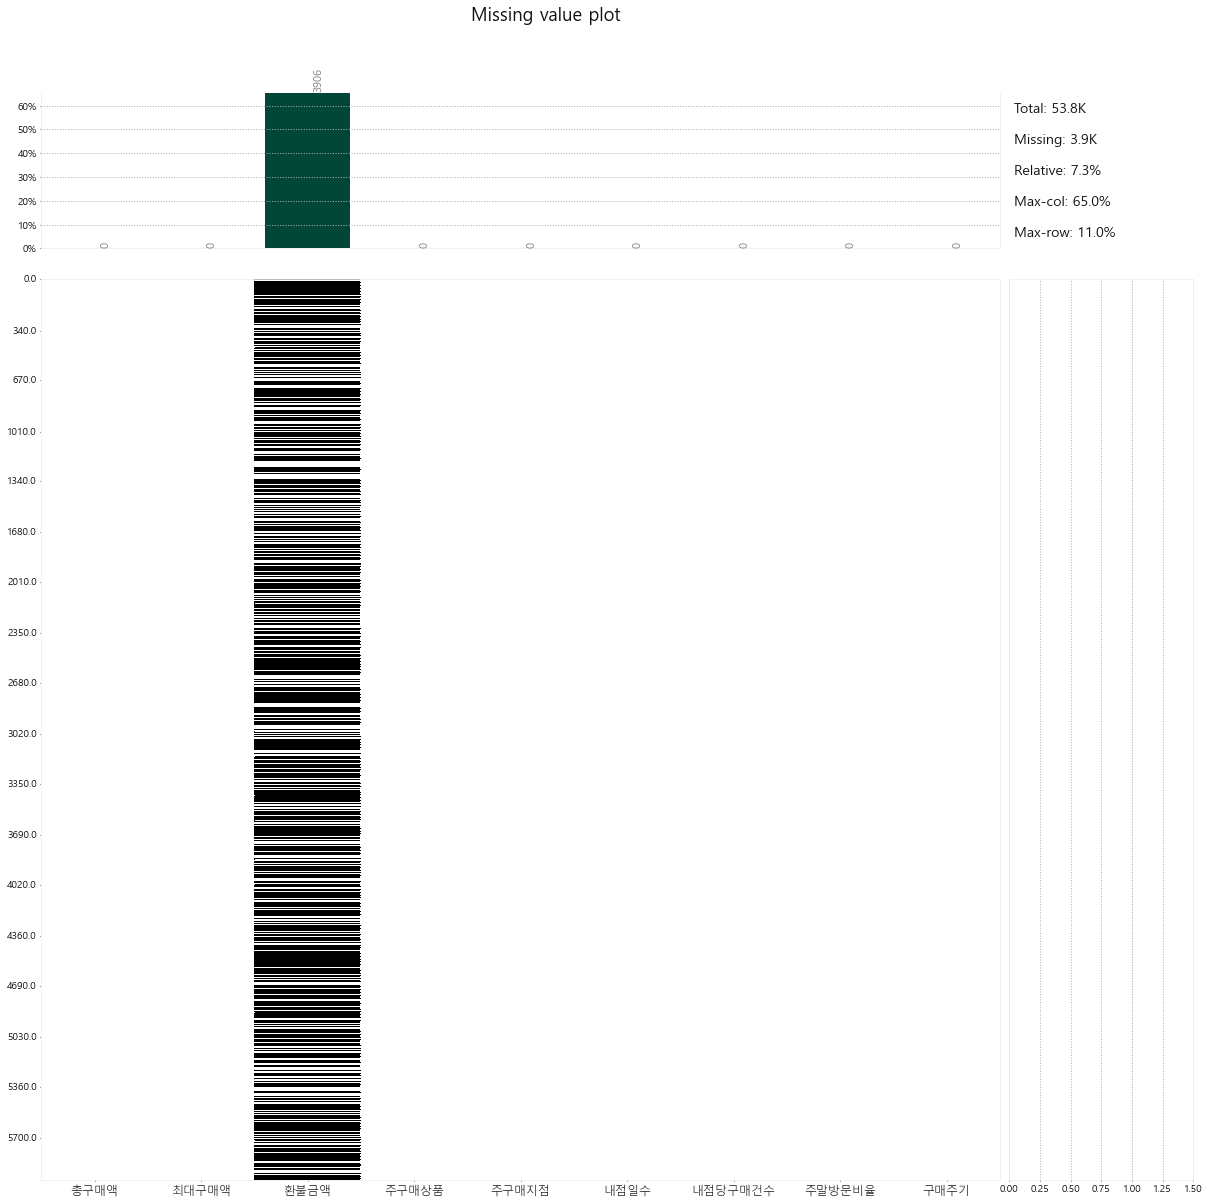

In [5]:
# 결측값 파악
klib.missingval_plot(features)

<AxesSubplot:xlabel='구매주기', ylabel='Density'>

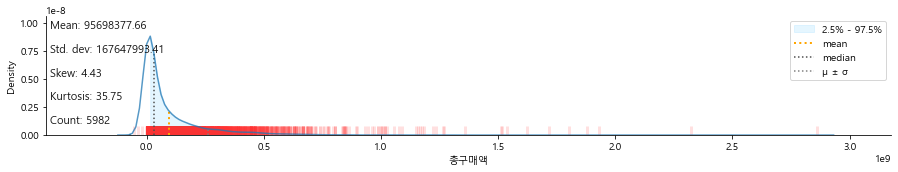

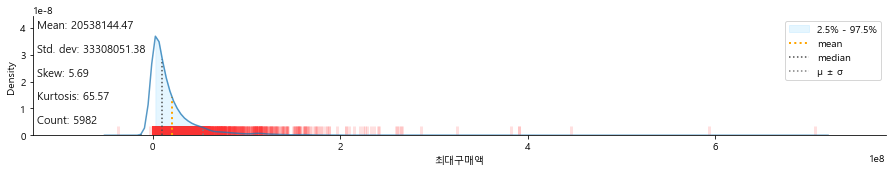

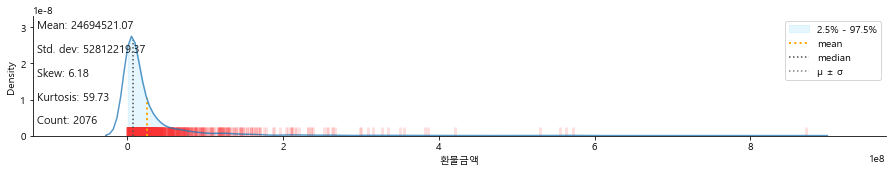

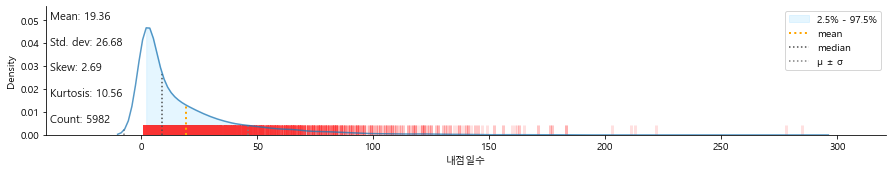

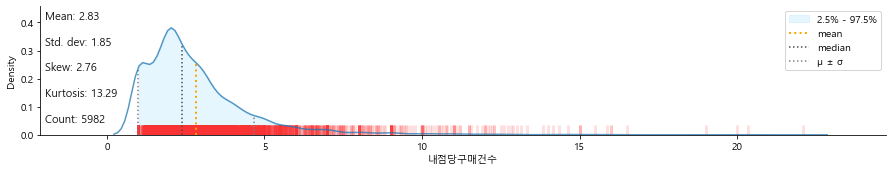

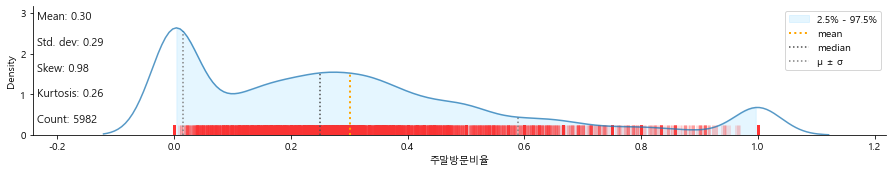

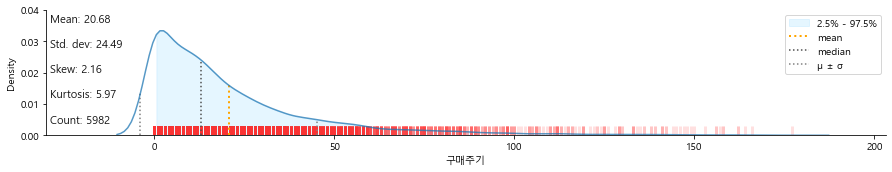

In [6]:
# 수치형 속성 파악
klib.dist_plot(features)

GridSpec(6, 2)

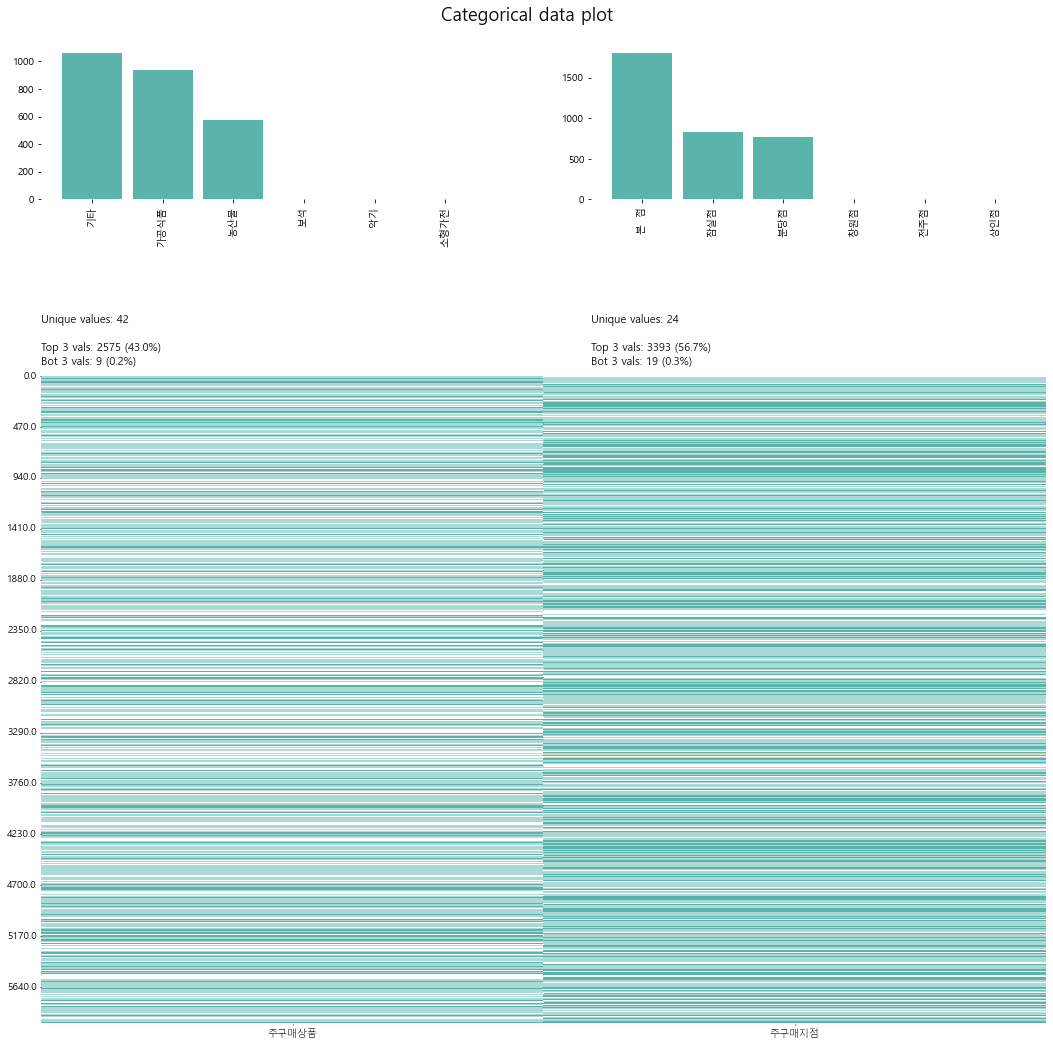

In [7]:
# 범주형 속성 파악
klib.cat_plot(features)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

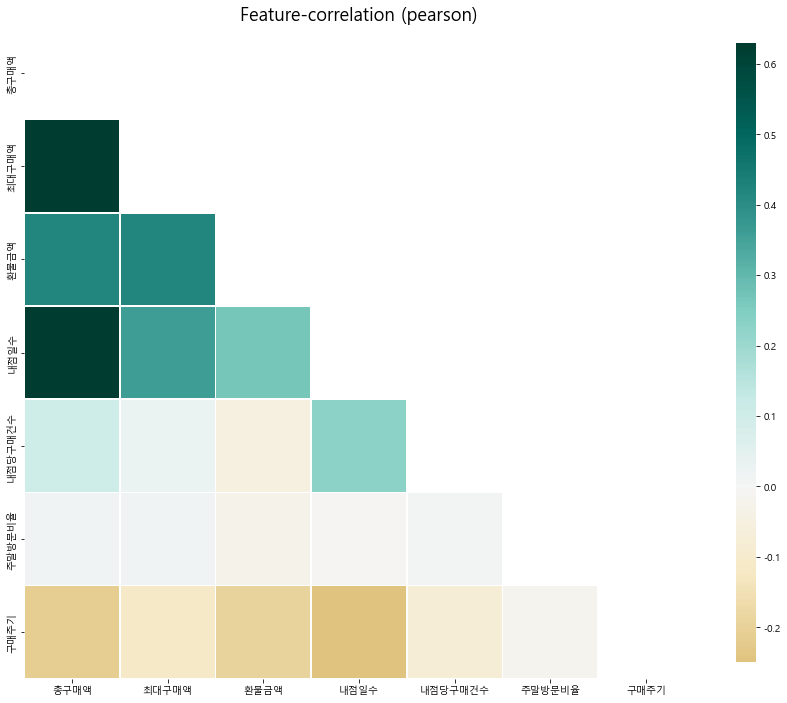

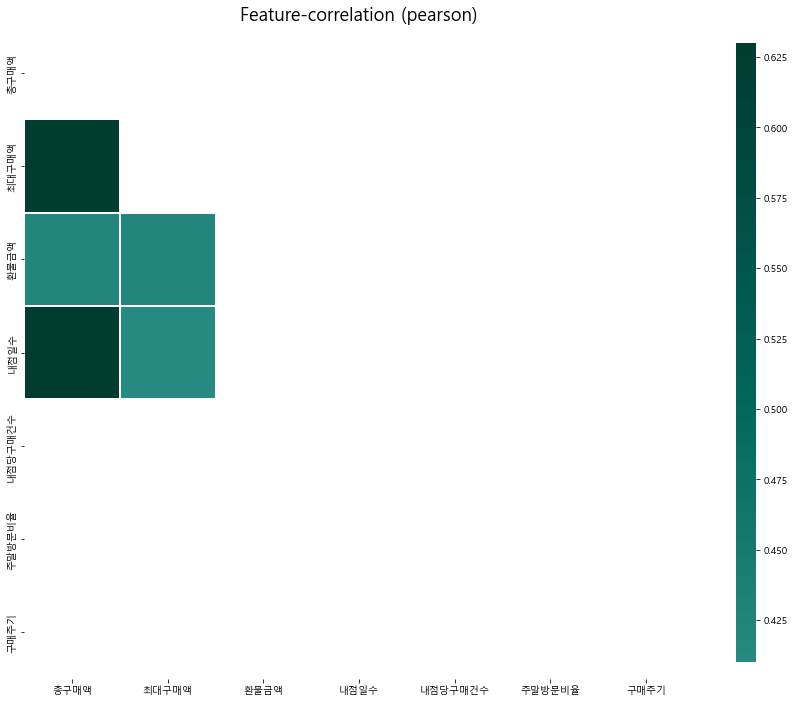

In [8]:
# 속성간 유사성 파악

klib.corr_plot(features, annot=False, figsize=(15,12))
klib.corr_plot(features, split='high', annot=False, figsize=(15,12))

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

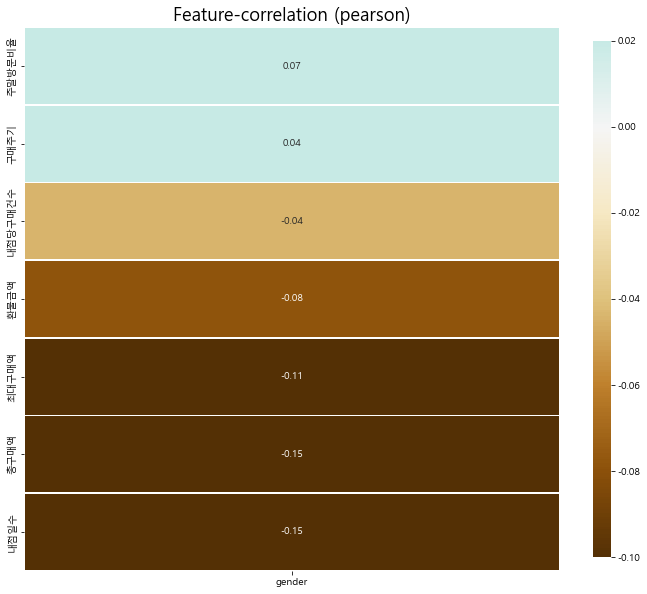

In [9]:
# 속성별 예측 능력 파악 

klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

## 4. Data Cleansing & Feature Engineering

In [10]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()

### [ WorkFlow ]
1) num, cat 피처 분류  
2) 각각의 피처에서 스케일링을 진행  
3) 각 파이프라인을 합친 후 모델 피팅 진행  

### Impute Missing Values

In [11]:
print('train data 결측치 비율 \n')
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * train[col].isnull().sum() / train[col].shape[0])
    print(msg)

train data 결측치 비율 

column:       총구매액	 Percent of NaN value: 0.00%
column:      최대구매액	 Percent of NaN value: 0.00%
column:       환불금액	 Percent of NaN value: 65.57%
column:      주구매상품	 Percent of NaN value: 0.00%
column:      주구매지점	 Percent of NaN value: 0.00%
column:       내점일수	 Percent of NaN value: 0.00%
column:    내점당구매건수	 Percent of NaN value: 0.00%
column:     주말방문비율	 Percent of NaN value: 0.00%
column:       구매주기	 Percent of NaN value: 0.00%


In [12]:
print('test data 결측치 비율 \n')
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * test[col].isnull().sum() / test[col].shape[0])
    print(msg)

test data 결측치 비율 

column:       총구매액	 Percent of NaN value: 0.00%
column:      최대구매액	 Percent of NaN value: 0.00%
column:       환불금액	 Percent of NaN value: 64.91%
column:      주구매상품	 Percent of NaN value: 0.00%
column:      주구매지점	 Percent of NaN value: 0.00%
column:       내점일수	 Percent of NaN value: 0.00%
column:    내점당구매건수	 Percent of NaN value: 0.00%
column:     주말방문비율	 Percent of NaN value: 0.00%
column:       구매주기	 Percent of NaN value: 0.00%


In [13]:
# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리
train['환불금액'].fillna(0,inplace = True)
test['환불금액'].fillna(0,inplace = True)
if len(num_features) > 0: 
    imputer = SimpleImputer(strategy="median").fit(train[num_features])
    train[num_features] = imputer.transform(train[num_features])
    test[num_features] =imputer.transform(test[num_features])
    features[num_features] = imputer.fit_transform(features[num_features])
if len(cat_features) > 0:  
    imputer = SimpleImputer(strategy="most_frequent").fit(train[cat_features])
    train[cat_features] = imputer.transform(train[cat_features])
    test[cat_features] =imputer.transform(test[cat_features])
    features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])

* NaN 값을 처리하기 위해 여러가지 방법을 쓸 수 있지만 NaN 값을 갖는 Column은 환불 금액 뿐이고 환불을 안한 고객은 환불 금액은 0원이므로 SimpleImputer을 사용하여 Value값을 0으로 채워줌
* 데이터의 num_features에 환불금액 외의 column의 NaN 값이 들어오는 상황에 대해 평균, Catfeatures 는 최빈값으로 대체해준다.
* __Mean 을 대체 값으로 설정한 이유는 EDA 과정에서 데이터의 왜도가 심해 Median과 데이터 스케일의 간격이 넓기 때문__

### Deal with Outliers

* Column 별 Boxtplot을 그려본 후 이상치 제거 방향 설정해보기

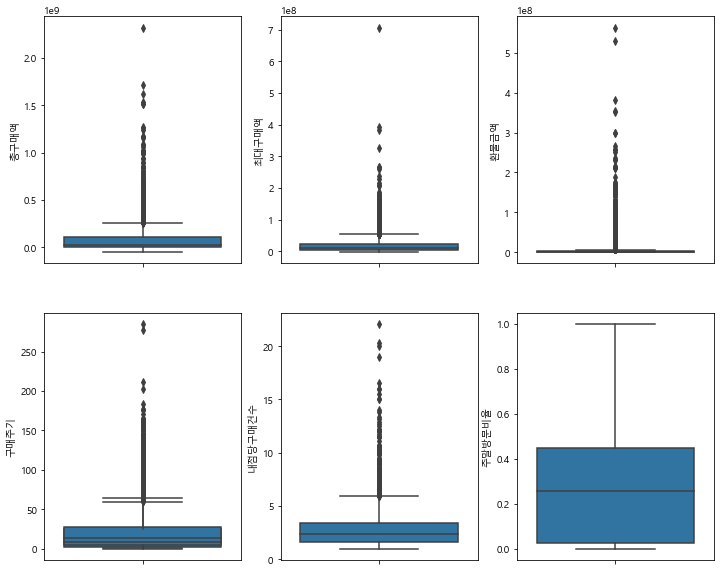

In [14]:
# 이상치 확인
fig, ax = plt.subplots(2,3,figsize = (12,10))
j = 0; k = 0;
for i in num_features:
    sns.boxplot(data = train[num_features], y = i,ax = ax[j][k])
    k+=1
    if k ==3:
        j=1;k=0
plt.show()

이상치를 모두 drop하기에 데이터 셋의 크기가 작으므로 하위 5% 상위 95% 의 데이터를 clip을 사용하여 대체

In [15]:
train[num_features] = train[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)
test[num_features] = test[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

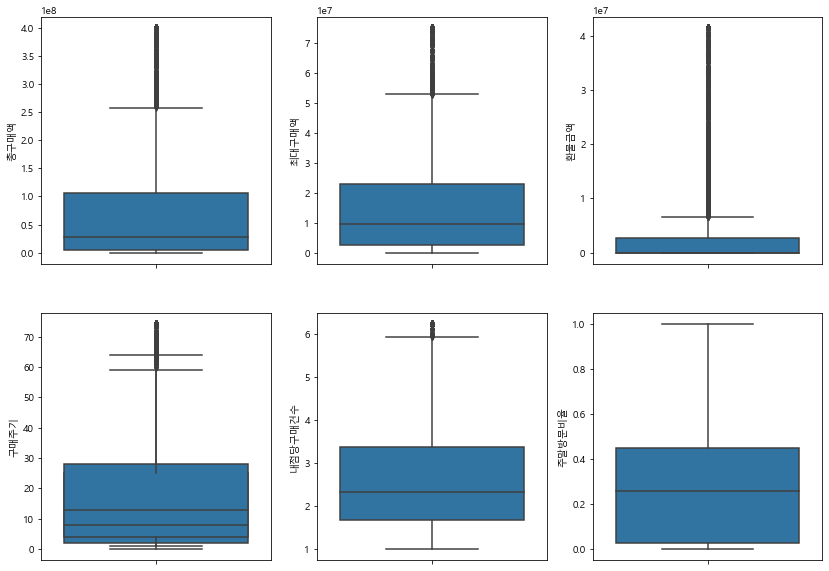

In [16]:
fig, ax = plt.subplots(2,3,figsize = (14,10))
j = 0; k = 0;
for i in num_features:
    sns.boxplot(data = train[num_features], y = i,ax = ax[j][k])
    k+=1
    if k ==3:
        j=1;k=0
plt.show()

def get_outlier(df=None,column=None,weight=1.5):
    
    column_x = df[column]
    # 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    quantile_25 = np.percentile(column_x.values,25)
    quantile_75 = np.percentile(column_x.values,75)
       
    # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 Dataframe index 반환
    outlier_index = column_x[(column_x < lowest_val) | (column_x > highest_val)].index
    return outlier_index

outlier_index = []
for i in num_features:
    for j in list(get_outlier(train[num_features],i)):
        outlier_index.append(j)
outlier_index = set(outlier_index)       

len(outlier_index)

Boxplot 을 그려 해 본 결과 환불금액 외에 이상치가 없기 때문에 환불 금액 이상치 index는 제거하기 보다 Scaling을 통해 영향력을 낮춘다

### Transform Features

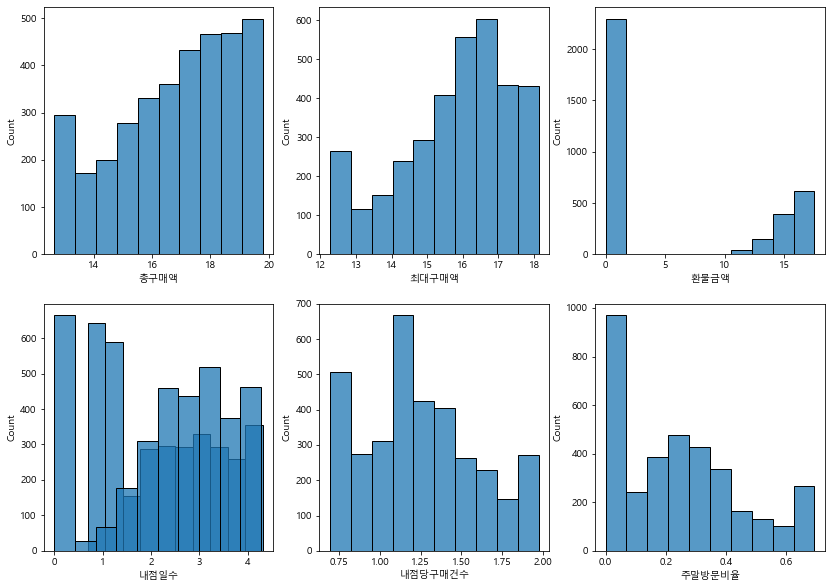

In [17]:
fig, ax = plt.subplots(2,3,figsize = (14,10))
j = 0; k = 0;
for i in num_features:
    sns.histplot(np.log1p(train[num_features][i]),bins = 10,ax = ax[j][k])
    k+=1
    if k ==3:
        j=1;k=0
plt.show()

In [18]:
# Scaling 준비
scaler_s = StandardScaler()
scaler_m = MinMaxScaler()
scaler_p = PowerTransformer()
scaler_n = Normalizer()

In [19]:
# 각 스케일 method를 각각 피팅
scaler_list = [scaler_s,scaler_m,scaler_p,scaler_n]
for i in range(4):
    scaler_list[i].fit(train[num_features])

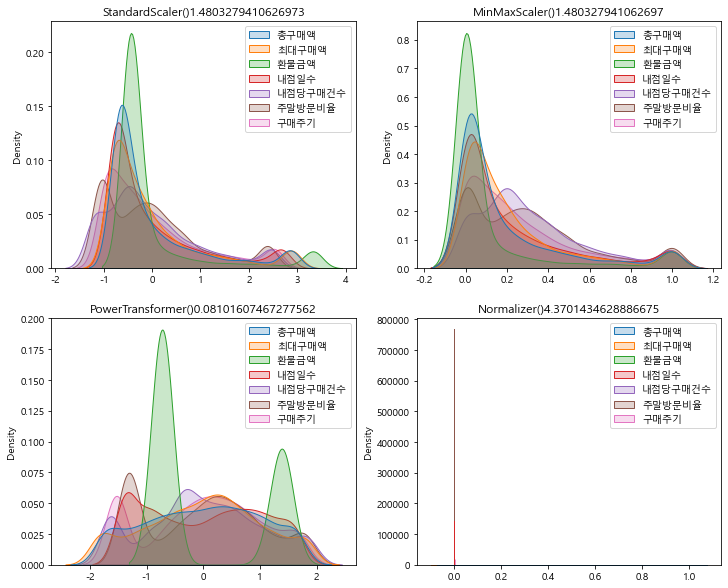

In [20]:
# 각 스케일링 기법들 간 분포 확인
fig, ax = plt.subplots(2,2,figsize = (12,10))
j = 0; k = 0;
for i in scaler_list:
    train1 = train.copy()
    train1[num_features] = i.transform(train[num_features])
    sns.kdeplot(data = train1, shade = True,ax = ax[j][k])
    ax[j][k].set_title(f'{i}{np.mean(train1[num_features].skew())}')
    k+=1
    if k == 2:
        j=1;k=0
del train1

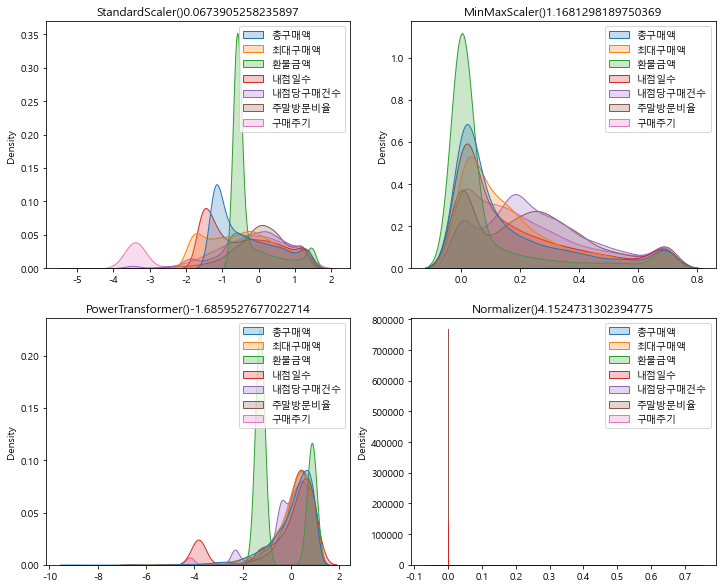

In [21]:
# 로그변환 적용 후 분포 확인
fig, ax = plt.subplots(2,2,figsize = (12,10))
j = 0; k = 0;
for i in scaler_list:
    train1 = train.copy()
    train1[num_features] = i.transform(train[num_features])
    sns.kdeplot(data = np.log1p(train1[num_features]), shade = True,ax = ax[j][k])
    ax[j][k].set_title(f'{i}{np.mean(np.log1p(train1[num_features]).skew())}')
    k+=1
    if k == 2:
        j=1;k=0
del train1

-> Scaling + log 변환을 해본 결과 PowerTransformation의 왜도가 가장 낮았으므로 `PowerTransformation`을 진행

In [22]:
train[num_features] = scaler_p.transform(train[num_features])
test[num_features] = scaler_p.transform(test[num_features])

### Encode Categorical Variables

In [23]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
# label 인코딩, mean 인코딩 등등 
# LR -> One-Hot-Encoding
# DF/RF/GBM -> Label 인코딩 가능

In [24]:
# OneHotEncoding 변환
if len(cat_features) > 0:
    train_one = pd.concat([train[num_features], pd.get_dummies(train[cat_features])], axis=1)
    test_one = pd.concat([test[num_features], pd.get_dummies(test[cat_features])], axis=1)
else:
    train_one= train[num_features]
    test_one = test[num_features]
bag = (set(train_one.columns) - set(test_one.columns))
for i in bag:
    test_one[i] = 0

In [25]:
# LabelEncoding 변환
encoder = LabelEncoder()
encoder.fit(train['주구매상품'])
labels = encoder.transform(train['주구매상품'])
labels = pd.Series(labels)

if len(cat_features) > 0:
    train_label = train.copy()
    test_label = test.copy()
    for i in cat_features:
        encoder = LabelEncoder()
        encoder.fit(train[i])
        labels = encoder.transform(train[i])
        train_label[i] = labels
        labels = encoder.transform(test[i])
        test_label[i] = labels
else:
    train_label = train[num_features]
    test_label = test[num_features]

### Feature Selection

#### 1. shap

In [26]:
# shap 패키지 설치
!pip install shap

In [27]:
import shap
import skimage

#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)    

* OneHotEncoder 적용 데이터

In [28]:
# 학습용과 제출용 데이터로 분리
s_X_train_o = train_one
s_X_test_o = test_one

In [29]:
# DF, based on which importance is checked
X_importance_o = s_X_test_o
#Explain model predictions using shap library:
model = LogisticRegression(random_state=0).fit(s_X_train_o, y_train)
explainer = shap.LinearExplainer(model, s_X_train_o)
shap_values = explainer.shap_values(X_importance_o)
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df_o = pd.DataFrame([X_importance_o.columns.tolist(), shap_sum.tolist()]).T
importance_df_o.columns = ['column_name', 'shap_importance']
importance_df_o = importance_df_o.sort_values('shap_importance', ascending=False)
importance_df_o

,column_name,shap_importance
2,환불금액,0.243475
3,내점일수,0.196885
18,주구매상품_디자이너,0.130077
5,주말방문비율,0.106886
48,주구매지점_강남점,0.081026
...,...,...
22,주구매상품_보석,0.000102
41,주구매상품_침구/수예,0.000057
8,주구매상품_가구,0.000031
23,주구매상품_생활잡화,0.000023


In [30]:
importance_df_o

,column_name,shap_importance
2,환불금액,0.243475
3,내점일수,0.196885
18,주구매상품_디자이너,0.130077
5,주말방문비율,0.106886
48,주구매지점_강남점,0.081026
...,...,...
22,주구매상품_보석,0.000102
41,주구매상품_침구/수예,0.000057
8,주구매상품_가구,0.000031
23,주구매상품_생활잡화,0.000023


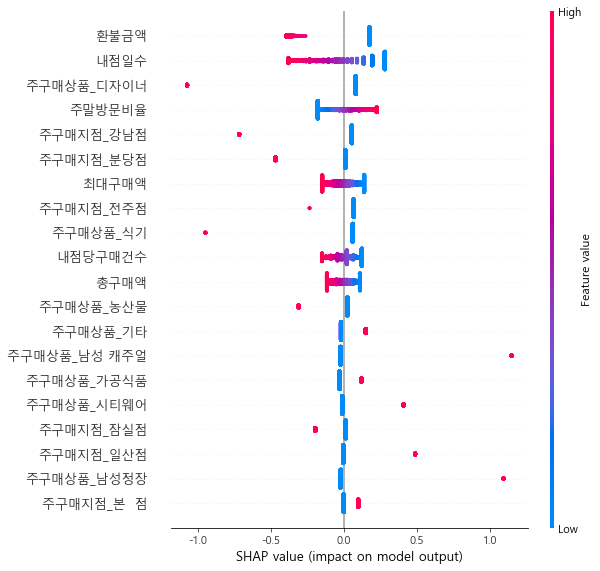

In [31]:
# summary
shap.summary_plot(shap_values[:,:], X_importance_o)

__< summary를 통해 알 수 있는 것 >__  
  
해당 변수가 빨간색을 띄면 target에 대해 양의 영향력이, 파란색을 띄면 음의 영향력이 존재함을 의미  
  
<font color = blue>__피쳐의 영향력이 가장 높은 `환불금액`,`내점일수`의 양, 음의 영향력 차이가 극명하다__
  

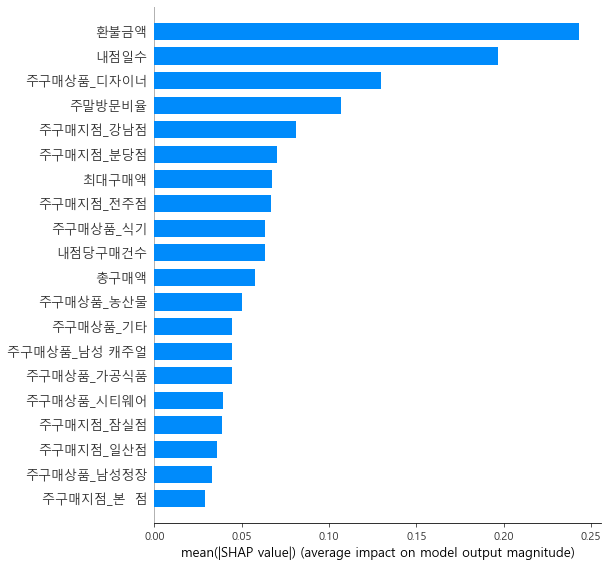

In [32]:
shap.summary_plot(shap_values, X_importance_o, plot_type = "bar")

In [33]:
# 중요도가 0인 feature를 제거 
features_selected = importance_df_o.query('shap_importance > 0.001').column_name
s_X_train_o = s_X_train_o[features_selected]
s_X_test_o = s_X_test_o[features_selected]
print(s_X_train_o.shape, s_X_test_o.shape)

(3500, 61) (2482, 61)


In [34]:
# GradientBoost 단일모델 cv
lr_clf = LogisticRegression(random_state=0)
models = [lr_clf]

print('<교차검증점수 평균>')
for model in models:
    print('{} : {}'.format(type(model).__name__,cross_val_score(model, s_X_train_o, y_train, cv = 5, scoring = 'roc_auc').mean()))

<교차검증점수 평균>
LogisticRegression : 0.6831853750021828


* LabelEncoder 적용 데이터

In [35]:
# 학습용과 제출용 데이터로 분리
s_X_train_l = train_label
s_X_test_l = test_label

In [36]:
# DF, based on which importance is checked
X_importance_l = s_X_test_l
#Explain model predictions using shap library:
model = GradientBoostingClassifier(random_state=0).fit(s_X_train_l, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance_l)
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df_l = pd.DataFrame([X_importance_l.columns.tolist(), shap_sum.tolist()]).T
importance_df_l.columns = ['column_name', 'shap_importance']
importance_df_l = importance_df_l.sort_values('shap_importance', ascending=False)
importance_df_l

,column_name,shap_importance
3,주구매상품,0.280346
2,환불금액,0.245233
5,내점일수,0.15286
7,주말방문비율,0.141616
1,최대구매액,0.129744
6,내점당구매건수,0.101248
0,총구매액,0.097879
4,주구매지점,0.07668
8,구매주기,0.070796


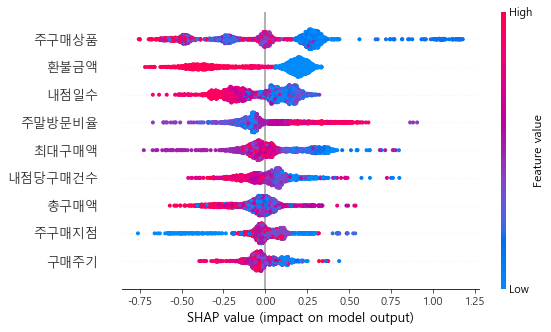

In [37]:
# summary
shap.summary_plot(shap_values, X_importance_l)

__< summary를 통해 알 수 있는 것 >__  
   
<font color = blue>__피쳐의 영향력이 가장 높은 `주구매상품`,`환불금액`의 양, 음의 영향력 차이가 극명하다__
  

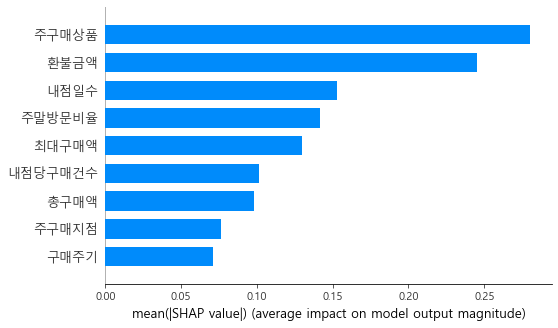

In [38]:
# 피쳐 중요도 시각화
shap.summary_plot(shap_values, X_importance_l, plot_type = "bar")

`shap_importance`가 0.1 이상이 피쳐를 선택

In [39]:
# 중요도가 0.1 이상인 feature 선택
features_selected = importance_df_l.query('shap_importance > 0.1').column_name
s_X_train_l = s_X_train_l[features_selected]
s_X_test_l = s_X_test_l[features_selected]
print(s_X_train_l.shape, s_X_test_l.shape)

(3500, 6) (2482, 6)


In [40]:
# GradientBoost 단일모델 cv
GB_clf = GradientBoostingClassifier(random_state=0)
models = [GB_clf]

print('<교차검증점수 평균>')
for model in models:
    print('{} : {}'.format(type(model).__name__,cross_val_score(model, s_X_train_l, y_train, cv = 5, scoring = 'roc_auc').mean()))

<교차검증점수 평균>
GradientBoostingClassifier : 0.6539346833523474


#### 2. SelectPercentile

* OneHotEncoder 적용 데이터

In [41]:
# 학습용과 제출용 데이터로 분리
p_X_train_o = train_one
p_X_test_o = test_one


(41, 0.6871819996574222)


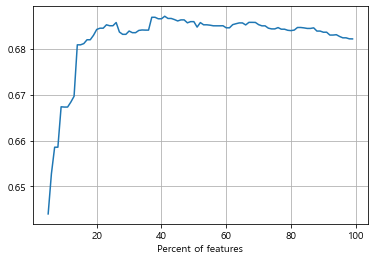

In [42]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state = 0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []

# 성능이 우수한 p 값 찾기 
# 피처가 큰 경우 샘플링해서 정할 수 있다. 
for p in tqdm_notebook(range(5,100,1)):
    X_new_o = SelectPercentile(percentile=p).fit_transform(p_X_train_o, y_train)    
    cv_score = cross_val_score(model, X_new_o, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [43]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다.
# p값 주변의 값들에서 임의의 값을 넣는 것이 좋음
fs = SelectPercentile(percentile=best_score[0]).fit(p_X_train_o, y_train)
p_X_train_o = fs.transform(p_X_train_o)
p_X_test_o = fs.transform(p_X_test_o)

print(p_X_train_o.shape)
print(train_one.iloc[:,:].columns[fs.get_support()].tolist())

(3500, 30)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주말방문비율', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_침구/수예', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_안양점', '주구매지점_전주점']


* LabelEncoder 적용 데이터

In [44]:
# 학습용과 제출용 데이터로 분리
p_X_train_l = train_label
p_X_test_l = test_label


(76, 0.6519075521883583)


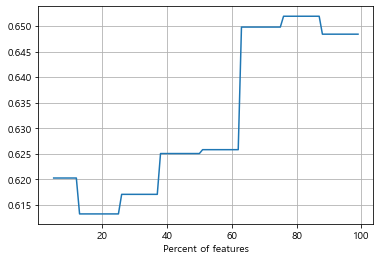

In [45]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = GradientBoostingClassifier(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []

# 성능이 우수한 p 값 찾기 
# 피처가 큰 경우 샘플링해서 정할 수 있다. 
for p in tqdm_notebook(range(5,100,1)):
    X_new_l = SelectPercentile(percentile=p).fit_transform(p_X_train_l, y_train)    
    cv_score = cross_val_score(model, X_new_l, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [46]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다.
# p값 주변의 값들에서 임의의 값을 넣는 것이 좋음
fs = SelectPercentile(percentile=best_score[0]).fit(p_X_train_l, y_train)
p_X_train_l = fs.transform(p_X_train_l)
p_X_test_l = fs.transform(p_X_test_l)

print(p_X_train_l.shape)
print(train_label.iloc[:,:].columns[fs.get_support()].tolist())

(3500, 7)
['총구매액', '최대구매액', '환불금액', '주구매상품', '내점일수', '내점당구매건수', '주말방문비율']


### Summary

__[ OneHot ]__  
  
shap : 0.6836683623626206  
<font color=red>__Select_P : 0.6875355140197292__</font>  
  
__[ Label ]__  
   
<font color=red>__shap : 0.6586624158742987__</font>  
Select_P : 0.6547253803821015  
  
***
__<font color = blue>OneHot 변환 데이터 -> `Select Percentile` 적용  
Lable 변환 데이터 -> `shap` 적용__

***

## 5. Hyperparameter Optimization

In [47]:
!pip install  bayesian-optimization

####  OneHotEncoding 적용 데이터

In [48]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
p_X_train_o, p_X_val_o, p_y_train_o, p_y_val_o = train_test_split(p_X_train_o, y_train, test_size=0.3, random_state=42)

* LogisticRegression

In [49]:
# 하이퍼 파라미터 범위

pbounds = {'C': (0, 10)}

def lr_opt(C):
    params = {'C' : C,
              'random_state':0,}
    
    lr_clf = LogisticRegression(**params)
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    score = cross_val_score(lr_clf, p_X_train_o, p_y_train_o, scoring='roc_auc', cv=skf, n_jobs=-1)
    return np.mean(score)

BO_lr = BayesianOptimization(f = lr_opt, pbounds = pbounds, random_state=0)
BO_lr.maximize(init_points=20, n_iter=20)

max_params_lr = BO_lr.max['params']
max_params_lr

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.6789   |  5.488    |
|  2        |  0.679    |  7.152    |
|  3        |  0.679    |  6.028    |
|  4        |  0.679    |  5.449    |
|  5        |  0.6789   |  4.237    |
|  6        |  0.679    |  6.459    |
|  7        |  0.6789   |  4.376    |
|  8        |  0.6791   |  8.918    |
|  9        |  0.6791   |  9.637    |
|  10       |  0.6789   |  3.834    |
|  11       |  0.679    |  7.917    |
|  12       |  0.6789   |  5.289    |
|  13       |  0.679    |  5.68     |
|  14       |  0.6791   |  9.256    |
|  15       |  0.6783   |  0.7104   |
|  16       |  0.6784   |  0.8713   |
|  17       |  0.6772   |  0.2022   |
|  18       |  0.6791   |  8.326    |
|  19       |  0.679    |  7.782    |
|  20       |  0.6791   |  8.7      |
|  21       |  0.6786   |  2.698    |
|  22       |  0.6786   |  1.896    |
|  23       |  0.6791   |  10.0     |
|  24       |  0.6788   |  3.3      |
|  25       

{'C': 8.698780531484848}

In [50]:
lr_clf = LogisticRegression(random_state = 0, **max_params_lr)

#### LabelEncoding 적용 데이터

In [51]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
s_X_train_l, s_X_val_l, s_y_train_l, s_y_val_l = train_test_split(s_X_train_l, y_train, test_size=0.3, random_state=42)

* RandomForest

In [52]:
pbounds = { 'n_estimators': (50,250),
            'max_depth': (5,15), 
            'max_features': (0.8,0.95),
            'min_samples_leaf': (1, 5)}

def rf_opt(n_estimators, max_depth, max_features, min_samples_leaf):
    params = {'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'min_samples_leaf' : int(round(min_samples_leaf))}

    rf = RandomForestClassifier(**params, n_jobs = -1, random_state = 0)
    skf = StratifiedKFold(n_splits=5, random_state = 0, shuffle = True)
    score = cross_val_score(rf, s_X_train_l, s_y_train_l, scoring = 'roc_auc', cv = skf, n_jobs = -1)
    return np.mean(score)


BO_rf = BayesianOptimization(f = rf_opt, pbounds = pbounds, random_state=0)
BO_rf.maximize(init_points=100, n_iter=20)

max_params_rf = BO_rf.max['params']
max_params_rf

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.6474   |  10.49    |  0.9073   |  3.411    |  159.0    |
|  2        |  0.6467   |  9.237    |  0.8969   |  2.75     |  228.4    |
|  3        |  0.6391   |  14.64    |  0.8575   |  4.167    |  155.8    |
|  4        |  0.6355   |  10.68    |  0.9388   |  1.284    |  67.43    |
|  5        |  0.6582   |  5.202    |  0.9249   |  4.113    |  224.0    |
|  6        |  0.6369   |  14.79    |  0.9199   |  2.846    |  206.1    |
|  7        |  0.6555   |  6.183    |  0.896    |  1.573    |  238.9    |
|  8        |  0.6417   |  10.22    |  0.8622   |  2.058    |  204.8    |
|  9        |  0.6426   |  9.562    |  0.8853   |  1.075    |  173.5    |
|  10       |  0.6452   |  11.12    |  0.8925   |  4.775    |  186.4    |
|  11       |  0.6454   |  8.595    |  0.8656   |  3.791    |  62.05    |
|  12       |  0.633    |  11.67    | 

|  67       |  0.6378   |  11.7     |  0.9178   |  2.127    |  167.3    |
|  68       |  0.6556   |  5.64     |  0.8728   |  4.91     |  225.3    |
|  69       |  0.6503   |  8.382    |  0.9442   |  1.927    |  239.9    |
|  70       |  0.6413   |  14.41    |  0.9199   |  3.522    |  224.9    |
|  71       |  0.6483   |  7.93     |  0.9273   |  3.472    |  52.65    |
|  72       |  0.6515   |  8.472    |  0.8222   |  4.927    |  145.7    |
|  73       |  0.6384   |  9.974    |  0.8959   |  2.474    |  77.38    |
|  74       |  0.6368   |  13.22    |  0.8285   |  3.045    |  94.86    |
|  75       |  0.6557   |  5.978    |  0.9293   |  4.892    |  242.2    |
|  76       |  0.6336   |  14.07    |  0.9161   |  2.333    |  66.22    |
|  77       |  0.6435   |  9.072    |  0.8348   |  1.53     |  60.69    |
|  78       |  0.6392   |  12.26    |  0.8017   |  4.082    |  79.39    |
|  79       |  0.6531   |  5.795    |  0.8134   |  3.688    |  99.07    |
|  80       |  0.6489   |  9.205    | 

{'max_depth': 5.05838564130869,
 'max_features': 0.9223646548166877,
 'min_samples_leaf': 3.113257453879818,
 'n_estimators': 233.17515876412884}

In [53]:
max_params_rf['n_estimators'] = int(max_params_rf['n_estimators'])
max_params_rf['max_depth'] = int(max_params_rf['max_depth'])
max_params_rf['min_samples_leaf'] = int(max_params_rf['min_samples_leaf'])

In [54]:
rf_clf = RandomForestClassifier(random_state = 0, **max_params_rf)

* XGB

In [55]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 100),
            'max_depth': (5,15),   
            'subsample': (0.8,0.95),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,  
        'gamma': gamma
    }
    
    xgb = XGBClassifier(**params, n_jobs=-1, random_state=0)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=0)
    score = cross_val_score(xgb, s_X_train_l, s_y_train_l, scoring='roc_auc', cv=skf, n_jobs=-1)
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)
BO_xgb.maximize(init_points=100, n_iter=20)

max_params_xgb = BO_xgb.max['params']
max_params_xgb

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.5868   |  2.744    |  1.076    |  11.03    |  77.24    |  0.8635   |
|  2        |  0.5951   |  3.229    |  0.662    |  13.92    |  98.18    |  0.8575   |
|  3        |  0.5807   |  3.959    |  0.7981   |  10.68    |  96.28    |  0.8107   |
|  4        |  0.6195   |  0.4356   |  0.04013  |  13.33    |  88.91    |  0.9305   |
|  5        |  0.5821   |  4.893    |  1.201    |  9.615    |  89.03    |  0.8177   |
|  6        |  0.6214   |  3.2      |  0.2236   |  14.45    |  76.09    |  0.8622   |
|  7        |  0.5628   |  1.323    |  1.164    |  9.562    |  78.42    |  0.8028   |
|  8        |  0.586    |  3.088    |  0.922    |  11.17    |  97.19    |  0.9023   |
|  9        |  0.5937   |  1.798    |  0.6612   |  11.98    |  53.01    |  0.9      |
|  10       |  0.6133   |  3.353    |  0.3235   |  6.2

|  58       |  0.5678   |  0.7407   |  1.473    |  9.784    |  74.87    |  0.8959   |
|  59       |  0.6134   |  1.843    |  0.214    |  13.22    |  59.49    |  0.8767   |
|  60       |  0.6069   |  1.122    |  0.1558   |  13.62    |  98.65    |  0.9441   |
|  61       |  0.58     |  4.533    |  1.163    |  8.331    |  54.06    |  0.8611   |
|  62       |  0.6123   |  1.161    |  0.2074   |  5.534    |  86.28    |  0.8017   |
|  63       |  0.633    |  3.853    |  0.229    |  5.795    |  54.48    |  0.9008   |
|  64       |  0.5871   |  1.227    |  0.6366   |  10.57    |  93.03    |  0.9091   |
|  65       |  0.6109   |  1.352    |  0.2059   |  5.554    |  65.08    |  0.8393   |
|  66       |  0.5723   |  2.281    |  1.028    |  11.96    |  64.18    |  0.857    |
|  67       |  0.5849   |  0.9058   |  1.185    |  5.568    |  84.85    |  0.9168   |
|  68       |  0.6098   |  3.887    |  0.3965   |  8.738    |  79.38    |  0.8409   |
|  69       |  0.6022   |  1.854    |  0.3036   |  9.5

|  116      |  0.584    |  2.615    |  1.232    |  5.107    |  53.73    |  0.8452   |
|  117      |  0.6046   |  2.615    |  0.5023   |  5.597    |  51.07    |  0.8791   |
|  118      |  0.6349   |  1.238    |  0.1027   |  5.774    |  53.2     |  0.8657   |
|  119      |  0.6174   |  1.205    |  0.1748   |  6.832    |  51.81    |  0.889    |
|  120      |  0.6369   |  2.78     |  0.09699  |  6.241    |  53.37    |  0.8156   |


{'gamma': 4.7794971968382525,
 'learning_rate': 0.01,
 'max_depth': 8.562503206587385,
 'n_estimators': 86.85565294659814,
 'subsample': 0.8}

In [56]:
max_params_xgb['n_estimators'] = int(max_params_xgb['n_estimators'])
max_params_xgb['max_depth'] = int(max_params_xgb['max_depth'])

In [57]:
xgb_clf = XGBClassifier(random_state = 0, **max_params_xgb)

* LGBM

In [58]:
pbounds = {
    'n_estimators':(50,800),
    'learning_rate':(0.001,1.5),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'subsample':(0.5, 0.95),
    'colsample_bytree':(0.5, 0.95),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 50),
    'reg_alpha':(0.001, 50)
}
def lgbm_opt(n_estimators, learning_rate, max_depth, num_leaves,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'max_bin':int(max_bin)
    }
    
    lgbm = LGBMClassifier(random_state=0, **params, n_jobs=-1)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=0)
    score = cross_val_score(lgbm, s_X_train_l, s_y_train_l, scoring='roc_auc', cv=skf, n_jobs=-1)
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=0)
BO_lgbm.maximize(init_points=100, n_iter=20)

max_params_lgbm = BO_lgbm.max['params']
max_params_lgbm

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6487   |  0.747    |  1.073    |  305.4    |  18.35    |  367.7    |  42.05    |  21.88    |  44.59    |  0.9336   |
|  2        |  0.6213   |  0.6725   |  1.188    |  269.2    |  19.04    |  744.2    |  6.404    |  4.357    |  1.012    |  0.8747   |
|  3        |  0.628    |  0.8502   |  1.305    |  489.5    |  25.97    |  396.1    |  50.39    |  5.915    |  32.0     |  0.5645   |
|  4        |  0.6489   |  0.9251   |  0.7833   |  213.2    |  9.937    |  630.7    |  30.28    |  28.42    |  0.9405   |  0.7779   |
|  5        |  0.6464   |  0.7754   |  0.9258   |  472.4    |  22.45    |  319.6    |  29.1     |  34.88    |  3.012    |  0.8      |
|  6        |  0.6542   |  0.8018   |  0.3164   |  73.17    | 

|  38       |  0.6434   |  0.8136   |  1.168    |  390.9    |  9.783    |  330.4    |  38.43    |  13.64    |  18.54    |  0.5887   |
|  39       |  0.6522   |  0.7069   |  0.06787  |  401.9    |  4.309    |  439.1    |  21.02    |  28.88    |  47.97    |  0.7905   |
|  40       |  0.6425   |  0.5159   |  0.6462   |  259.9    |  18.09    |  561.0    |  19.21    |  6.444    |  19.63    |  0.9304   |
|  41       |  0.6461   |  0.5842   |  1.356    |  276.5    |  15.71    |  711.5    |  30.43    |  36.21    |  19.95    |  0.9068   |
|  42       |  0.6443   |  0.8105   |  1.05     |  170.6    |  24.7     |  527.0    |  16.88    |  8.028    |  39.82    |  0.9316   |
|  43       |  0.6448   |  0.7062   |  0.8869   |  430.3    |  15.72    |  763.9    |  37.7     |  41.04    |  45.44    |  0.867    |
|  44       |  0.6432   |  0.5717   |  0.9437   |  205.2    |  3.881    |  368.0    |  18.04    |  42.45    |  1.666    |  0.9315   |
|  45       |  0.6524   |  0.6599   |  0.5357   |  18.0     | 

|  76       |  0.6395   |  0.794    |  1.09     |  273.1    |  5.314    |  353.8    |  27.13    |  16.05    |  1.498    |  0.8318   |
|  77       |  0.6428   |  0.5494   |  0.9099   |  354.6    |  21.04    |  769.4    |  8.404    |  43.36    |  1.46     |  0.7407   |
|  78       |  0.6421   |  0.6819   |  0.7868   |  188.9    |  7.717    |  64.34    |  34.13    |  42.14    |  18.66    |  0.6003   |
|  79       |  0.6498   |  0.5362   |  0.1289   |  118.5    |  5.0      |  248.8    |  6.101    |  3.281    |  42.81    |  0.573    |
|  80       |  0.6461   |  0.7519   |  1.16     |  233.6    |  6.601    |  199.7    |  28.85    |  26.41    |  17.47    |  0.8517   |
|  81       |  0.6465   |  0.838    |  1.391    |  24.19    |  28.87    |  344.4    |  56.46    |  34.54    |  49.37    |  0.8417   |
|  82       |  0.6479   |  0.664    |  0.7521   |  194.4    |  12.95    |  245.7    |  32.75    |  34.09    |  13.87    |  0.736    |
|  83       |  0.6534   |  0.5528   |  0.2406   |  32.94    | 

|  113      |  0.6512   |  0.7411   |  0.4788   |  131.8    |  10.6     |  64.66    |  9.637    |  25.14    |  7.02     |  0.5846   |
|  114      |  0.6482   |  0.8683   |  0.06534  |  403.5    |  28.96    |  715.7    |  54.34    |  39.1     |  17.69    |  0.687    |
|  115      |  0.644    |  0.6055   |  1.087    |  427.0    |  11.4     |  764.9    |  31.54    |  39.97    |  46.13    |  0.6959   |
|  116      |  0.6152   |  0.5981   |  1.275    |  113.7    |  4.488    |  251.8    |  3.822    |  0.4276   |  48.39    |  0.7654   |
|  117      |  0.6499   |  0.927    |  1.204    |  310.8    |  8.013    |  784.5    |  57.3     |  31.45    |  44.06    |  0.7858   |
|  118      |  0.6534   |  0.7093   |  0.03466  |  213.0    |  12.26    |  434.3    |  19.1     |  20.81    |  25.88    |  0.6013   |
|  119      |  0.6449   |  0.6465   |  1.488    |  144.6    |  2.602    |  140.4    |  35.25    |  33.88    |  27.95    |  0.8688   |
|  120      |  0.6524   |  0.7223   |  0.3011   |  120.2    | 

{'colsample_bytree': 0.5012164462520762,
 'learning_rate': 0.9711477841871601,
 'max_bin': 304.19219617784336,
 'max_depth': 19.662188299108646,
 'n_estimators': 772.0777398801819,
 'num_leaves': 3.046043748942461,
 'reg_alpha': 34.8244250526418,
 'reg_lambda': 40.68411880644347,
 'subsample': 0.7294132384797128}

In [59]:
max_params_lgbm['n_estimators'] = int(max_params_lgbm['n_estimators'])
max_params_lgbm['max_depth'] = int(max_params_lgbm['max_depth'])
max_params_lgbm['max_bin'] = int(max_params_lgbm['max_bin'])
max_params_lgbm['num_leaves'] = int(max_params_lgbm['num_leaves'])

In [60]:
lgbm_clf = LGBMClassifier(random_state = 0, **max_params_lgbm)

* AdaBoost

In [61]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 100)}

def ada_opt(learning_rate, n_estimators):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators))
    }
    
    ada = AdaBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=0)
    score = cross_val_score(ada, s_X_train_l, s_y_train_l, scoring='roc_auc', cv=skf, n_jobs=-1)
    return np.mean(score)

BO_ada = BayesianOptimization(f = ada_opt, pbounds = pbounds, random_state=0)
BO_ada.maximize(init_points=100, n_iter=20)

max_params_ada = BO_ada.max['params']
max_params_ada

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
|  1        |  0.6464   |  0.8277   |  85.76    |
|  2        |  0.647    |  0.9081   |  77.24    |
|  3        |  0.6483   |  0.6412   |  82.29    |
|  4        |  0.648    |  0.662    |  94.59    |
|  5        |  0.6373   |  1.446    |  69.17    |
|  6        |  0.6411   |  1.19     |  76.44    |
|  7        |  0.6454   |  0.8564   |  96.28    |
|  8        |  0.6577   |  0.1158   |  54.36    |
|  9        |  0.6548   |  0.04013  |  91.63    |
|  10       |  0.6393   |  1.169    |  93.5     |
|  11       |  0.6292   |  1.468    |  89.96    |
|  12       |  0.6469   |  0.6976   |  89.03    |
|  13       |  0.6558   |  0.1862   |  82.0     |
|  14       |  0.6544   |  0.2236   |  97.23    |
|  15       |  0.6461   |  0.7876   |  70.73    |
|  16       |  0.6531   |  0.4042   |  88.71    |
|  17       |  0.6474   |  0.6897   |  78.42    |
|  18       |  0.6543   |  0.038    |  80.88    |


|  100      |  0.658    |  0.09646  |  71.72    |
|  101      |  0.6452   |  0.7783   |  94.45    |
|  102      |  0.6564   |  0.1645   |  80.94    |
|  103      |  0.6416   |  1.249    |  81.99    |
|  104      |  0.6553   |  0.2222   |  71.76    |
|  105      |  0.6573   |  0.1601   |  71.6     |
|  106      |  0.6564   |  0.2572   |  54.34    |
|  107      |  0.6548   |  0.2748   |  96.03    |
|  108      |  0.6563   |  0.1316   |  90.72    |
|  109      |  0.6576   |  0.156    |  54.22    |
|  110      |  0.6429   |  1.248    |  58.41    |
|  111      |  0.6548   |  0.05311  |  84.47    |
|  112      |  0.6542   |  0.2398   |  84.51    |
|  113      |  0.6542   |  0.4906   |  56.26    |
|  114      |  0.6555   |  0.2188   |  56.16    |
|  115      |  0.6445   |  0.9051   |  85.66    |
|  116      |  0.6567   |  0.2085   |  55.87    |
|  117      |  0.6567   |  0.09797  |  55.68    |
|  118      |  0.655    |  0.3201   |  55.69    |
|  119      |  0.6514   |  0.5625   |  94.37    |


{'learning_rate': 0.09646344888257466, 'n_estimators': 71.72083127790604}

In [62]:
max_params_ada['n_estimators'] = int(max_params_ada['n_estimators'])

In [63]:
ada_clf = AdaBoostClassifier(random_state = 0, **max_params_ada)

* KNN

In [64]:
def knn_objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 20, step = 1) # 검색할 이웃의 수
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance']) # 예측에 사용하는 가중치
    knn_metric = trial.suggest_categorical('metric' , ['euclidean', 'manhattan', 'minkowski']) # 거리 측정 방식을 변경


    classifier_obj = KNeighborsClassifier(n_neighbors = knn_n_neighbors,
                                        weights = knn_weights,
                                        metric = knn_metric,
                                        n_jobs = -1)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=0)
    score = cross_val_score(classifier_obj, s_X_train_l, s_y_train_l, cv = skf, scoring = 'roc_auc', n_jobs = -1)
    roc_auc = score.mean()
    return roc_auc

knn_study = optuna.create_study(direction="maximize")
knn_study.optimize(knn_objective, n_trials = 100) # 최대 100번 실행
print('Best socre :',knn_study.best_trial.values)

[I 2021-11-23 18:05:02,779] A new study created in memory with name: no-name-e942e132-a397-46a6-8b2b-378dea3632cc
[I 2021-11-23 18:05:02,828] Trial 0 finished with value: 0.6163637930072048 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6163637930072048.
[I 2021-11-23 18:05:02,875] Trial 1 finished with value: 0.6112680327763897 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.6163637930072048.
[I 2021-11-23 18:05:02,918] Trial 2 finished with value: 0.5863745686809146 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6163637930072048.
[I 2021-11-23 18:05:02,961] Trial 3 finished with value: 0.6004763097218306 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6163637930072048.
[I 2021-11-23 18:05:03,006] Trial 4 finished with value: 0.61

[I 2021-11-23 18:05:04,701] Trial 37 finished with value: 0.6382325936076437 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:04,751] Trial 38 finished with value: 0.6196021109375813 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:04,803] Trial 39 finished with value: 0.5986365518374315 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:04,853] Trial 40 finished with value: 0.6351051841854195 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:04,909] Trial 41 finished with value: 0.6445216653634962 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan'}. Best is tr

[I 2021-11-23 18:05:06,657] Trial 75 finished with value: 0.6445216653634962 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:06,709] Trial 76 finished with value: 0.6408082845309288 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:06,762] Trial 77 finished with value: 0.6382325936076437 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:06,815] Trial 78 finished with value: 0.6432968881020587 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 24 with value: 0.6445216653634962.
[I 2021-11-23 18:05:06,865] Trial 79 finished with value: 0.6445216653634962 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan'}. Best is t

Best socre : [0.6445216653634962]


In [65]:
knn_clf = KNeighborsClassifier(**knn_study.best_params, n_jobs = -1)

* MLPClassifier

In [66]:
def MLP_objective(trial):
    MLP_learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    MLP_activation = trial.suggest_categorical('activation', ['tanh', 'relu']) 
    MLP_solver = trial.suggest_categorical('solver' , ['sgd', 'adam']) 

    classifier_obj = MLPClassifier(learning_rate = MLP_learning_rate,
                                        activation = MLP_activation,
                                        solver = MLP_solver)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=0)
    score = cross_val_score(classifier_obj, s_X_train_l, s_y_train_l, cv = skf, scoring = 'roc_auc', n_jobs = -1)
    roc_auc = score.mean()
    return roc_auc

MLP_study = optuna.create_study(direction="maximize")
MLP_study.optimize(MLP_objective, n_trials = 20) # 최대 20번 실행
print('Best socre :',MLP_study.best_trial.values)

[I 2021-11-23 18:05:07,966] A new study created in memory with name: no-name-1f25c5a9-31f2-47ff-a413-dcf59ad4c56c
[I 2021-11-23 18:05:10,138] Trial 0 finished with value: 0.6484001221322473 and parameters: {'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.6484001221322473.
[I 2021-11-23 18:05:11,319] Trial 1 finished with value: 0.651897062970891 and parameters: {'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd'}. Best is trial 1 with value: 0.651897062970891.
[I 2021-11-23 18:05:13,458] Trial 2 finished with value: 0.6493626203912072 and parameters: {'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam'}. Best is trial 1 with value: 0.651897062970891.
[I 2021-11-23 18:05:15,500] Trial 3 finished with value: 0.6498155577934606 and parameters: {'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam'}. Best is trial 1 with value: 0.651897062970891.
[I 2021-11-23 18:05:17,739] Trial 4 finished wi

Best socre : [0.6563296374726948]


In [67]:
MLP_clf = MLPClassifier(**MLP_study.best_params)

#### Fitting Model

In [68]:
lr_clf.fit(p_X_train_o, p_y_train_o)
rf_clf.fit(s_X_train_l, s_y_train_l)
xgb_clf.fit(s_X_train_l, s_y_train_l)
lgbm_clf.fit(s_X_train_l, s_y_train_l)
ada_clf.fit(s_X_train_l, s_y_train_l)
knn_clf.fit(s_X_train_l, s_y_train_l)
MLP_clf.fit(s_X_train_l, s_y_train_l)

[18:05:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MLPClassifier(activation='tanh', solver='sgd')

In [69]:
lr_clf_score = lr_clf.score(p_X_val_o, p_y_val_o)
rf_clf_score = rf_clf.score(s_X_val_l, s_y_val_l)
xgb_clf_score = xgb_clf.score(s_X_val_l, s_y_val_l)
lgbm_clf_score = lgbm_clf.score(s_X_val_l, s_y_val_l)
ada_clf_score = ada_clf.score(s_X_val_l, s_y_val_l)
knn_clf_score = knn_clf.score(s_X_val_l, s_y_val_l)
MLP_clf_score = MLP_clf.score(s_X_val_l, s_y_val_l)

In [70]:
print('LogisticRegression : {}'.format(lr_clf_score))
print('RandomForest : {}'.format(rf_clf_score))
print('XGBoost : {}'.format(xgb_clf_score))
print('LGBM : {}'.format(lgbm_clf_score))
print('AdaBoost : {}'.format(ada_clf_score))
print('KNeighbors : {}'.format(knn_clf_score))
print('MLPClassifier : {}'.format(MLP_clf_score))

LogisticRegression : 0.6771428571428572
RandomForest : 0.6533333333333333
XGBoost : 0.6533333333333333
LGBM : 0.6514285714285715
AdaBoost : 0.6533333333333333
KNeighbors : 0.6580952380952381
MLPClassifier : 0.6628571428571428


score가 같은 모델 `predict_proba`를 통해 결과 값 확인

In [71]:
# LGBM - XGB
print('LGBM : {}'.format(lgbm_clf.predict_proba(s_X_val_l)))
print('=============================')
print('XGB : {}'.format(xgb_clf.predict_proba(s_X_val_l)))

LGBM : [[0.53232166 0.46767834]
 [0.51511691 0.48488309]
 [0.70961352 0.29038648]
 ...
 [0.59903363 0.40096637]
 [0.65586819 0.34413181]
 [0.73050143 0.26949857]]
XGB : [[0.539641   0.46035898]
 [0.51160693 0.48839307]
 [0.6397836  0.3602164 ]
 ...
 [0.6011975  0.3988025 ]
 [0.6361575  0.36384252]
 [0.63120973 0.36879027]]


In [72]:
# AdaBoost - KNN
print('AdaBoost : {}'.format(ada_clf.predict_proba(s_X_val_l)))
print('=============================')
print('KNN : {}'.format(knn_clf.predict_proba(s_X_val_l)))

AdaBoost : [[0.50208761 0.49791239]
 [0.50135625 0.49864375]
 [0.52292753 0.47707247]
 ...
 [0.51470479 0.48529521]
 [0.52135026 0.47864974]
 [0.54078479 0.45921521]]
KNN : [[0.65 0.35]
 [0.55 0.45]
 [0.7  0.3 ]
 ...
 [0.7  0.3 ]
 [0.8  0.2 ]
 [0.75 0.25]]


***

## 6. Model Ensemble

#### Correlation between models

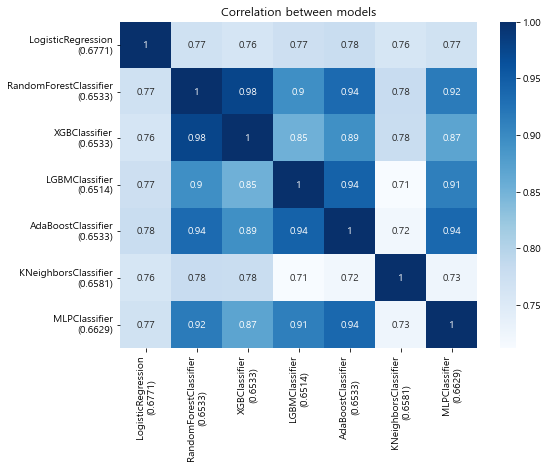

In [73]:
clf_tune = dict()
#선형 모델과 트리 모델을 다르게 계산하기에 선형 모델을 추가한다면 이 리스트에
#추가할 수 있다.
clfs_tuned = [lr_clf,rf_clf,xgb_clf,lgbm_clf,ada_clf,knn_clf,MLP_clf]
clf_name = [str(i).split('(')[0] for i in clfs_tuned]
clf_score = [lr_clf_score,rf_clf_score,xgb_clf_score,lgbm_clf_score,ada_clf_score,knn_clf_score,MLP_clf_score]
pred_results = []
i = 0 
for clf in clfs_tuned:
    if clf == lr_clf:
        pred = clf.predict_proba(p_X_val_o)[:,1]
        name = f'{clf_name[i]}\n({clf_score[i]:.4f})'
    else:
        pred = clf.predict_proba(s_X_val_l)[:,1]
        name = f'{clf_name[i]}\n({clf_score[i]:.4f})'
    pred_results.append(pd.Series(pred, name=name))
    i+=1
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

In [74]:
j=0
for i in clf_name:
    clf_tune[i] = clfs_tuned[j]
    j+=1
linear = ['LogisticRegression'] 

In [75]:
# 베이지안 최적화를 통해 튜닝이 완료된 모델들
clf_tune

{'LogisticRegression': LogisticRegression(C=8.698780531484848, random_state=0),
 'RandomForestClassifier': RandomForestClassifier(max_depth=5, max_features=0.9223646548166877,
                        min_samples_leaf=3, n_estimators=233, random_state=0),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=4.7794971968382525,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.01, max_delta_step=0, max_depth=8,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=86, n_jobs=12, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'LGBMClassifier': LGBMClassifier(colsample_bytree=0.5012164462520762,
                learning_rate=0.9711477841871601, max_

#### Mean agreement vs. Performance

In [76]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

LogisticRegression\n(0.6771)        0.769455
RandomForestClassifier\n(0.6533)    0.879652
XGBClassifier\n(0.6533)             0.855762
LGBMClassifier\n(0.6514)            0.848515
AdaBoostClassifier\n(0.6533)        0.868485
KNeighborsClassifier\n(0.6581)      0.746919
MLPClassifier\n(0.6629)             0.855199
dtype: float64

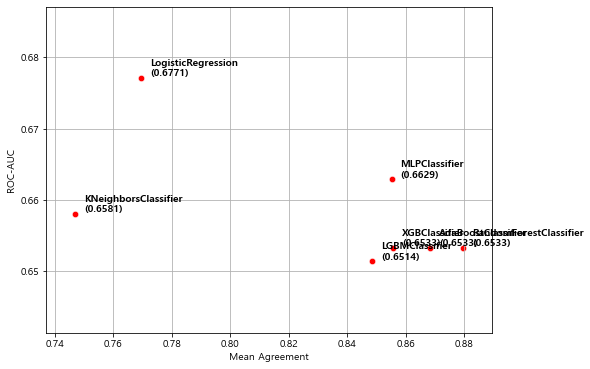

In [77]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]+0.0003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

#### Averaging Ensemble

In [78]:
# score 확인
clf_score
lr_clf_score,rf_clf_score,xgb_clf_score,lgbm_clf_score,ada_clf_score,knn_clf_score,MLP_clf_score

(0.6771428571428572,
 0.6533333333333333,
 0.6533333333333333,
 0.6514285714285715,
 0.6533333333333333,
 0.6580952380952381,
 0.6628571428571428)

In [79]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'XGBClassifier',
    'LGBMClassifier',
    'AdaBoostClassifier',
]
clf_name
models_for_ensemble = [clf for clf in clf_name if clf in selected]

In [80]:
# 모델별 가중 평균을 구하는 방법도 써보자
max_score = 0
for p in tqdm_notebook([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            # 모델의 모든 조합을 생성하여 가장 best를 찾는다.
            if p == 0:
                gm = []
                for name in models:
                    if name in linear:
                        score = clf_tune[name].predict_proba(p_X_val_o)[:,1]
                        gm.append(score)
                    else:
                        score = clf_tune[name].predict_proba(s_X_val_l)[:,1]
                        gm.append(score)
                pred_mean = gmean([score for score in gm], axis=0)
# Linear 모델 안에 있는 모델은 인코딩 방법을 다르게 해야하기 때문에 Select percentile을 적용한 
# 원-핫 인코딩 p_X_val_o에 적용시킨다. Tree 기반 모델에 대해서 Shap 과 Label인코딩을 적용한 s_X_val_l 에 대해 
# predict_proba를 적용하여 기하평균을 적용하였다.
            else:
                scores = []
                for name in models:
                    if name in linear:
                        score = clf_tune[name].predict_proba(p_X_val_o)[:,1]
                        scores.append(score)
                    else:
                        score = clf_tune[name].predict_proba(s_X_val_l)[:,1]
                        scores.append(score)
                preds =[score for score in gm]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(p_y_val_o, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name in models]), score))


p=0
LogisticRegression●AdaBoostClassifier
0.7071043494331699


#### Stacking

In [81]:
# 2-layer stacking
# Initialize 1st level estimators

# 사용하지 않을 모델 주석처리
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    #'XGBClassifier',
    'LGBMClassifier',
    'AdaBoostClassifier'
]

estimators = [(name, clf) for name, clf in zip(clf_name,clfs_tuned) if name in selected]

if set(linear) & set(estimators) == 0: 
    stk_clf = StackingClassifier(
            estimators=estimators, final_estimator=LGBMClssifier(random_state=0), cv=3)
    stk_clf.fit(s_X_train_l, s_y_train_l)
    print(roc_auc_score(s_y_val_l, stk_clf.predict_proba(s_X_val_l)[:,1]))
else:     
    stk_clf = StackingClassifier(
            estimators=estimators, final_estimator=LogisticRegression(random_state=0), cv=3)
    stk_clf.fit(p_X_train_o, p_y_train_o)
    print(roc_auc_score(p_y_val_o, stk_clf.predict_proba(p_X_val_o)[:,1]))  
# linear 모델을 사용하지 않는다면 가장 y_val_l과 x_val_l을 사용
# 전체적인 모델에서 Stacking을 할 때 Linear 모델을 적용한다면 One-Hot을 사용한 피처를 fitting시켜야 하기 때문에
# p_X_train_o로 피팅을 시킨다.

0.7055825786739753


In [84]:
best_avg_ensemble

(0, ('LogisticRegression', 'AdaBoostClassifier'), 0.7071043494331699)

## 7. Deployment

In [82]:
# Averaging ensemble로 예측한 submission: 
best_avg_ensemble
predict = []
for model in best_avg_ensemble[1]:
    if model in linear:# 모델이 선형모델이라면 one-hot 피처를 기반으로 확률 추출, 아니면 label인코딩 기반
        pred = clf_tune[model].predict_proba(p_X_test_o)[:,1]
        predict.append(pred)
    else:
        pred = clf_tune[model].predict_proba(s_X_test_l)[:,1]
        predict.append(pred)
if p == 0:
    pred_mean = gmean([pred for pred in predict], axis=0)s
else:
    pred_mean = (np.sum(np.array(predict)**p, axis=0) / len(best_avg_ensemble[1]))**(1/p)
pred_mean = pd.DataFrame(pred_mean)
result = pd.concat([test_id,pred_mean],axis = 1)
result.columns = ['cust_id','gender']

# Stacking ensemble로 예측한 submission: 
pd.DataFrame({'cust_id': test_id, 'gender': stk_clf.predict_proba(p_X_test_o)[:,1]}).to_csv('submission_stk.csv', index=False)

<font color="#CC3D3D"><p>
# End